# Frequency domain analysis using Bode/Nyquist plots

**CDS 110, Winter 2024** <br>
Richard M. Murray
</center>

The purpose of this lecture is to introduce tools that can be used for frequency domain modeling and analysis of linear systems.  It illustrates the use of a variety of frequency domain analysis and plotting tools.

In [1]:
# Import standard packages needed for this exercise
import numpy as np
import matplotlib.pyplot as plt
import math

from math import pi, sin, cos

import control as ct
print("python-control", ct.__version__)

python-control 0.10.1.dev32+gdbc998de


## Stable system: servomechanism

We start with a simple example a stable system for which we wish to design a simple controller and analyze its performance, demonstrating along the way that basic frequency domain analysis functions in the Python control toolbox (python-control).

Consider a simple mechanism for positioning a mechanical arm whose equations of motion are given by

$$
J \ddot \theta = -b \dot\theta - k r\sin\theta + \tau_\text{m},
$$

which can be written in state space form as

$$
\frac{d}{dt} \begin{bmatrix} \theta \\ \theta \end{bmatrix} =
  \begin{bmatrix} \dot\theta \\ -k r \sin\theta / J - b\dot\theta / J \end{bmatrix}
  + \begin{bmatrix} 0 \\ 1/J \end{bmatrix} \tau_\text{m}.
$$

The system consists of a spring loaded arm that is driven by a  motor, as shown below.

<center><img src="https://www.cds.caltech.edu/~murray/courses/cds110/sp2024/servomech-diagram.png" alt="servomech-diagram" width="240"></center>

The motor applies a torque that twists the arm against a linear spring and moves the end of the arm across a rotating platter. The input to the system is the motor torque $\tau_\text{m}$. The force exerted by the spring is a nonlinear function of the head position due to the way it is attached.

The system parameters are given by

$$
k = 1,\quad J = 100,\quad b = 10,
\quad r = 1,\quad l = 2,\quad \epsilon = 0.01.
$$

and we assume that time is measured in msec and distance in cm.  (The constants here are made up and don't necessarily reflect a real disk drive, though the units and time constants are motivated by computer disk drives.)

The system dynamics can be modeled in python-control using a `NonlinearIOSystem` object, which we create with the `nlsys` function:

In [2]:
# Parameter values
servomech_params = {
    'J': 100,             # Moment of inertial of the motor
    'b': 10,              # Angular damping of the arm
    'k': 1,               # Spring constant
    'r': 1,               # Location of spring contact on arm
    'l': 2,               # Distance to the read head
    'eps': 0.01,          # Magnitude of velocity-dependent perturbation
}

# State derivative
def servomech_update(t, x, u, params):
    # Extract the configuration and velocity variables from the state vector
    theta = x[0]                # Angular position of the disk drive arm
    thetadot = x[1]             # Angular velocity of the disk drive arm
    tau = u[0]                  # Torque applied at the base of the arm

    # Get the parameter values
    J, b, k, r = map(params.get, ['J', 'b', 'k', 'r'])

    # Compute the angular acceleration
    dthetadot = 1/J * (
        -b * thetadot - k * r * np.sin(theta) + tau)

    # Return the state update law
    return np.array([thetadot, dthetadot])

# System output (end of arm)
def servomech_output(t, x, u, params):
    l = params['l']
    return np.array([l * x[0]])

# System dynamics
servomech = ct.nlsys(
    servomech_update, servomech_output, name='servomech',
    params=servomech_params,
    states=['theta_', 'thdot_'],
    outputs=['y'], inputs=['tau'])

print(servomech)
print("\nParams:", servomech.params)

<NonlinearIOSystem>: servomech
Inputs (1): ['tau']
Outputs (1): ['y']
States (2): ['theta_', 'thdot_']

Update: <function servomech_update at 0x1436b1120>
Output: <function servomech_output at 0x1436b1080>

Params: {'J': 100, 'b': 10, 'k': 1, 'r': 1, 'l': 2, 'eps': 0.01}


### Linearization

To study the open loop dynamicsof the system, we compute the linearization of the dynamics about the equilibrium point corresponding to $\theta_\text{e} = 15^\circ$.

In [3]:
# Convert the equilibrium angle to radians
theta_e = (15 / 180) * np.pi

# Compute the input required to hold this position
u_e = servomech.params['k'] * servomech.params['r'] * np.sin(theta_e)
print("Equilibrium torque = %g" % u_e)

# Linearize the system about the equilibrium point
P = servomech.linearize([theta_e, 0], u_e, name='P_ss')
P.name = 'P_ss'  # TODO: fix in nlsys_improvements
print("Linearized dynamics:", P)
print("Zeros: ", P.zeros())
print("Poles: ", P.poles())
print("")

# Transfer function representation
P_tf = ct.tf(P, name='P_tf')
print(P_tf)

Equilibrium torque = 0.258819
Linearized dynamics: <StateSpace>: P_ss
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[ 0.          1.        ]
     [-0.00965926 -0.1       ]]

B = [[0.  ]
     [0.01]]

C = [[2. 0.]]

D = [[0.]]

Zeros:  []
Poles:  [-0.05+0.08461239j -0.05-0.08461239j]

<TransferFunction>: P_tf
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         0.02
----------------------
s^2 + 0.1 s + 0.009659



### Open loop frequency response

A standard method for understanding the dynamics is to plot the output of the system in response to sinusoids with unit magnitude at different frequencies.

We use the `frequency_response` function to plot the step response of the linearized, open-loop system.

array([[list([<matplotlib.lines.Line2D object at 0x143d33980>])],
       [list([<matplotlib.lines.Line2D object at 0x143b464b0>])]],
      dtype=object)

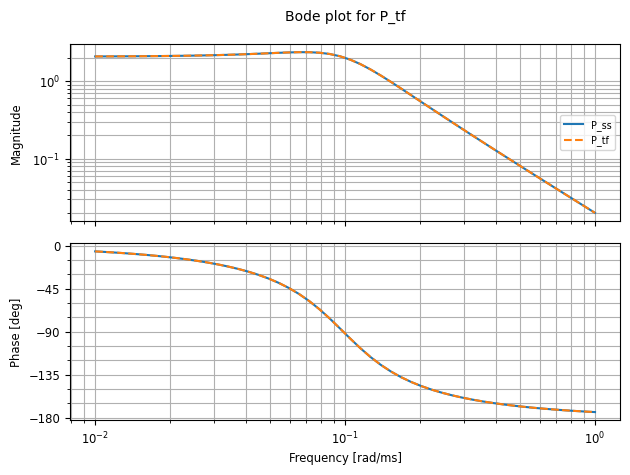

In [4]:
# Reset the frequency response label to correspond to a time unit of ms
ct.set_defaults('freqplot', freq_label="Frequency [rad/ms]")

# Frequency response
freqresp = ct.frequency_response(P, np.logspace(-2, 0))
freqresp.plot()

# Equivalent command
ct.bode_plot(P_tf, np.logspace(-2, 0), '--')

### Feedback control design

We next design a feedback controller for the system using a proportional integral controller, which has transfer function

$$
C(s) = \frac{k_\text{p} s + k_\text{i}}{s}
$$

We will learn how to choose $k_\text{p}$ and $k_\text{i}$ more formally in W9.  For how we just pick different values to see how the dynamics are impacted.

In [5]:
kp = 1
ki = 1

# Create tf from numerator/denominator coefficients
C = ct.tf([kp, ki], [1, 0], name='C')
print(C)

# Alternative method: define "s" and use algebra
s = ct.tf('s')
C = ct.tf(kp + ki/s, name='C')
print(C)

<TransferFunction>: C
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s + 1
-----
  s

<TransferFunction>: C
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


s + 1
-----
  s



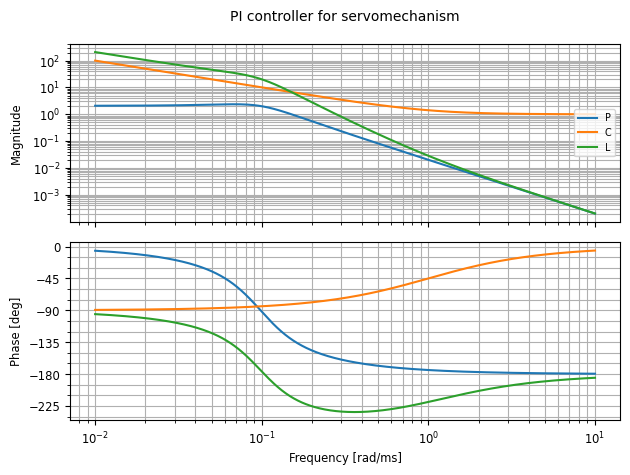

In [6]:
# Loop transfer function
L = P * C
ct.bode_plot([P, C, L], label=['P', 'C', 'L'])
ct.suptitle("PI controller for servomechanism")

Note that L = P * C corresponds to addition in both the magnitude and the phase.

### Nyquist analysis

To check stability (and eventually robustness), we use the Nyquist criterion.

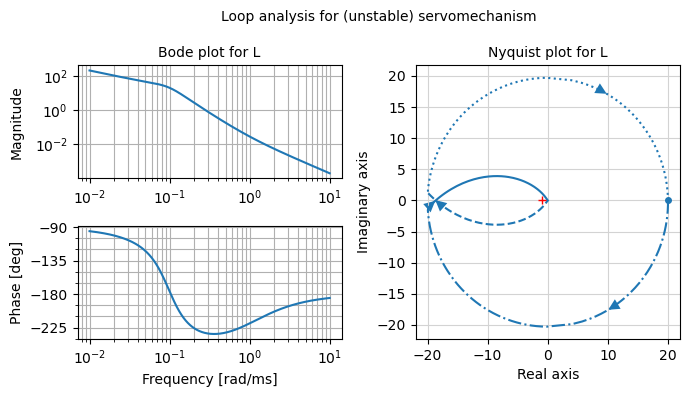

In [7]:
fig = plt.figure(figsize=[7, 4])
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3)
ct.bode_plot(L, ax=[ax1, ax2])

# Tidy up the figure a bit
fig.align_labels()
ax1.set_title("Bode plot for L", fontsize='medium')

ax2 = plt.subplot(1, 2, 2)
ct.nyquist_plot(L, ax=ax2, title="")
plt.title("Nyquist plot for L", fontsize='medium')

ct.suptitle("Loop analysis for (unstable) servomechanism")

We see from this plot that the loop transfer function encircles the -1 point => closed loop system should be unstable.  We can check this by making use of additional features of Nyquist analysis.

N = encirclements:  2
P = RHP poles of L:  0
Z = N + P = RHP zeros of 1 + L: 2
Zeros of (1 + L) =  [-0.26792107+0.j        0.08396054+0.259999j  0.08396054-0.259999j]



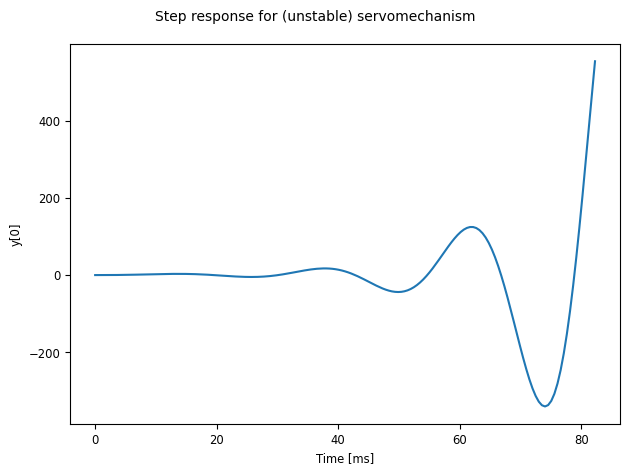

In [8]:
# Get the Nyquist *response*, so that we can get back encirclements
nyqresp = ct.nyquist_response(L)
print("N = encirclements: ", nyqresp.count)
print("P = RHP poles of L: ", np.sum(np.real(L.poles()) > 0))
print("Z = N + P = RHP zeros of 1 + L:", np.sum(np.real((1 + L).zeros()) > 0))
print("Zeros of (1 + L) = ", (1 + L).zeros())
print("")

T = ct.feedback(L)
ct.step_response(T).plot(
    title="Step response for (unstable) servomechanism",
    time_label="Time [ms]");

### Poles on the $j\omega$ axis

Note that we have a pole at 0 (due to the integrator in the controller).  How is this handled?

A: use a small loop to the right around poles on the $j\omega$ axis => not inside the contour.

To see this, we use the `nyquist_response` function, which returns the contour used to compute the Nyquist curve.  If we zoom in on the contour near the origin, we see how the outer edge of the Nyquist curve is computed.

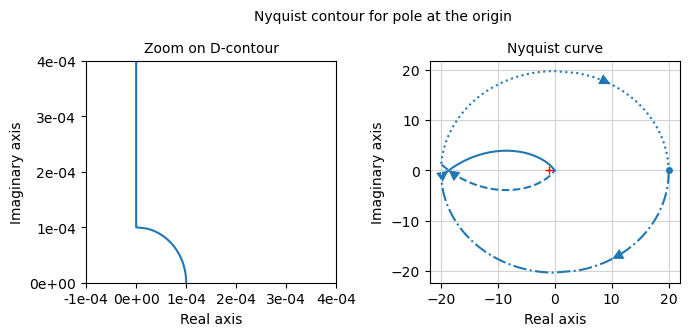

In [9]:
fig = plt.figure(figsize=[7, 5.8])

# Plot the D contour
ax1 = plt.subplot(2, 2, 1)
plt.plot(np.real(nyqresp.contour), np.imag(nyqresp.contour))
plt.axis([-1e-4, 4e-4, 0, 4e-4])
plt.xlabel('Real axis')
plt.ylabel('Imaginary axis')
plt.title("Zoom on D-contour", size='medium')

# Clean up the display of the units
from matplotlib import ticker
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))

ax2 = plt.subplot(2, 2, 2)
ct.nyquist_plot(L, ax=ax2)
plt.title("Nyquist curve", size='medium')

ct.suptitle("Nyquist contour for pole at the origin")

### Second iteration feedback control design

We now redesign the control system to give something that is stable.  We can do this by moving the zero for the controller to a lower frequency, so that the phase lag from the integrator does not overlap with the phase lag from the system dynamics.

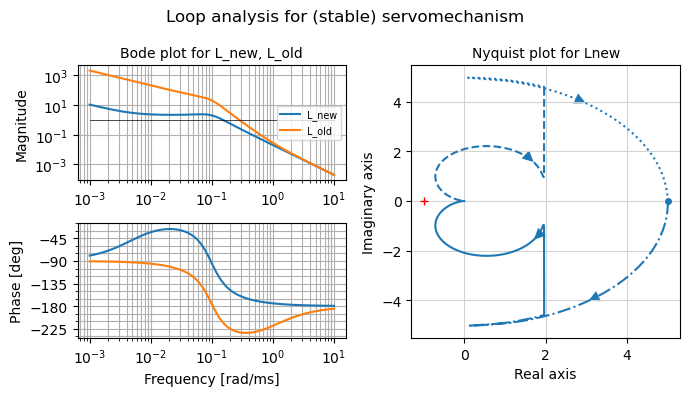

In [10]:
# Change the frequency response to avoid crossing over -180 with large gain
Cnew = ct.tf(kp + (ki/200)/s, name='C_new')
Lnew = ct.tf(P * Cnew, name='L_new')

plt.figure(figsize=[7, 4])
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3)
ct.bode_plot([Lnew, L], ax=[ax1, ax2], label=['L_new', 'L_old'])

# Clean up the figure a bit
ax1.loglog([1e-3, 1e1], [1, 1], 'k', linewidth=0.5)
ax1.set_title("Bode plot for L_new, L_old", size='medium')

ax3=plt.subplot(1, 2, 2)
ct.nyquist_plot(Lnew, max_curve_magnitude=5, ax=ax3)
ax3.set_title("Nyquist plot for Lnew", size='medium')

plt.suptitle("Loop analysis for (stable) servomechanism")
plt.tight_layout()

We see now that we have no encirclements, and so the system should be stable.

Note however that the Nyquist curve is close to the -1 point => not *that* stable.

Text(0.5, 0.98, 'Step response for (stable) spring-mass system')

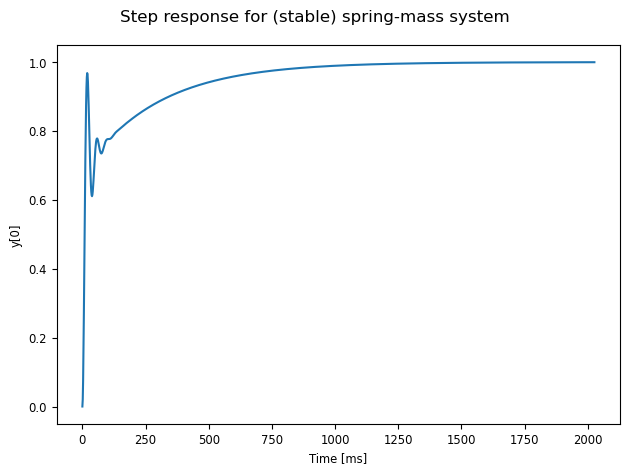

In [11]:
# Compute the transfer function from r to y
Tnew = ct.feedback(Lnew)
ct.step_response(Tnew).plot(time_label="Time [ms]")
plt.suptitle("Step response for (stable) spring-mass system")

### Third iteration feedback control design (via loop shaping)

To get a better design, we use a PID controller to shape the frequency response so that we get high gain at low frequency and low phase at crossover.

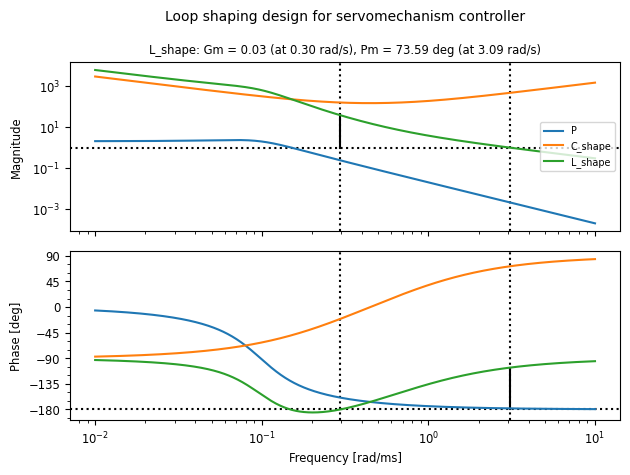

In [12]:
# Design parameters
Td = 1                    # Set to gain crossover frequency
Ti = Td * 10              # Set to low frequency region
kp = 500                  # Tune to get desired bandwith

# Updated gains
kp = 150
Ti = Td * 5; kp = 150

# Compute controller parmeters
ki = kp/Ti
kd = kp * Td

# Controller transfer function
ctrl_shape = kp + ki / s + kd * s

# Frequency response (open loop) - use this to help tune your design
ltf_shape = ct.tf(P_tf * ctrl_shape, name='L_shape')

ct.frequency_response([P, ctrl_shape]).plot(label=['P', 'C_shape'])
ct.frequency_response(ltf_shape).plot(margins=True)

ct.suptitle("Loop shaping design for servomechanism controller")
plt.tight_layout()

Text(0.5, 0.98, 'Step response for servomechanism with PID controller')

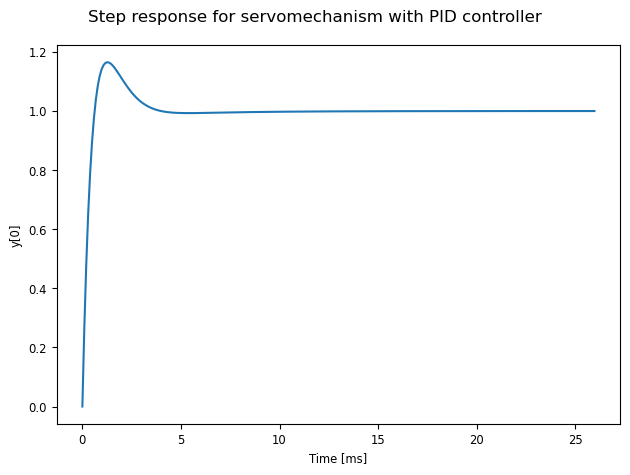

In [13]:
# Compute the transfer function from r to y
T_shape = ct.feedback(ltf_shape)
ct.step_response(T_shape).plot(time_label="Time [ms]")
plt.suptitle("Step response for servomechanism with PID controller")

### Closed loop frequency response

We can also look at the closed loop frequency response to understand how different inputs affect different outputs.  The `gangof4` function computes the standard transfer functions:

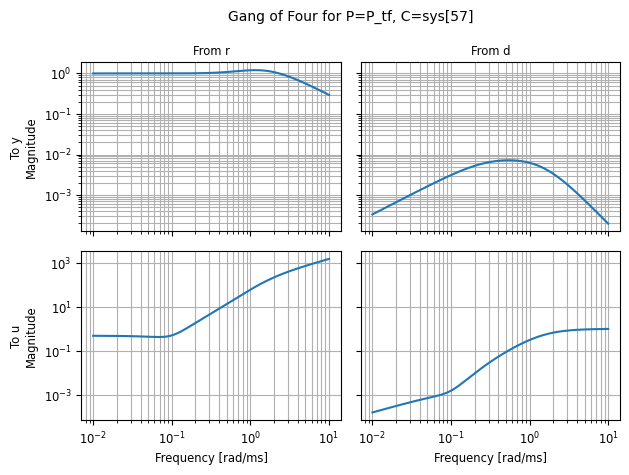

In [14]:
ct.gangof4(P_tf, ctrl_shape);

### Stability margins

Another standard set of analysis tools is to identify the gain, phase, and stability margins for the sytem:

* **Gain margin:** the maximimum amount of additional gain that we can put into the loop and still maintain stability.
* **Phase margin:** the maximum amount of additional phase (lag) that we can put into the loop and still maintain stability.
* **Stability margin:** the maximum amount of combined gain and phase at the critical frequency that can be put into the loop and still maintain stability.

The first two of the items can be computed either by looking at the frequeny response or by using the `margin` command.

The stabilty margin is the minimum distance between -1 and $L(jw)$, which is just the minimum value of $|1 - L(j\omega)



Gm = inf (at nan rad/ms)
Pm =  47 deg (at 0.15 rad/ms)
Sm = 0.6 (at 0.19 rad/ms)


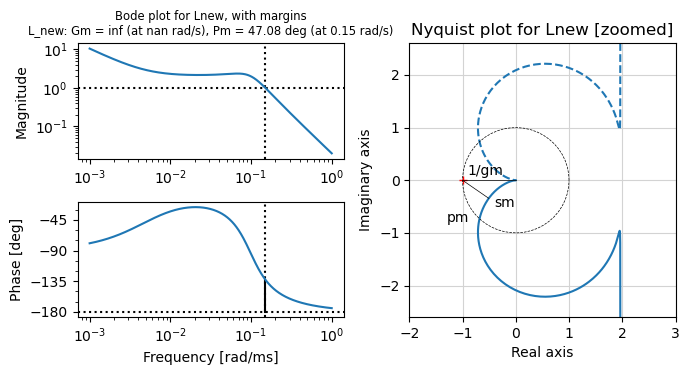

In [15]:
plt.figure(figsize=[7, 4])

# Gain and phase margin on Bode plot
ax1 = plt.subplot(2, 2, 1)
plt.title("Bode plot for Lnew, with margins")
ax2 = plt.subplot(2, 2, 3)
ct.bode_plot(Lnew, ax=[ax1, ax2], margins=True)

# Compute gain and phase margin
gm, pm, wpc, wgc = ct.margin(Lnew)
print(f"Gm = {gm:2.2g} (at {wpc:.2g} rad/ms)")
print(f"Pm = {pm:3.2g} deg (at {wgc:.2g} rad/ms)")

# Compute the stability margin
resp = ct.frequency_response(1 + Lnew)
sm = np.min(resp.magnitude)
wsm = resp.omega[np.argmin(resp.magnitude)]
print(f"Sm = {sm:2.2g} (at {wsm:.2g} rad/ms)")

# Plot the Nyquist curve
ax3 = plt.subplot(1, 2, 2)
ct.nyquist_plot(Lnew, ax=ax3)
plt.title("Nyquist plot for Lnew [zoomed]")
plt.axis([-2, 3, -2.6, 2.6])

#
# Annotate it to see the margins
#

# Gain margin (special case here, since infinite)
Lgm = 0
plt.plot([-1, Lgm], [0, 0], 'k-', linewidth=0.5)
plt.text(-0.9, 0.1, "1/gm")

# Phase margin
theta = np.linspace(0, 2 * pi)
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=0.5)
plt.text(-1.3, -0.8, "pm")

# Stability margin
Lsm = Lnew(wsm * 1j)
plt.plot([-1, Lsm.real], [0, Lsm.imag], 'k-', linewidth=0.5)
plt.text(-0.4, -0.5, "sm")

plt.suptitle("")
plt.tight_layout()

## Unstable system: inverted pendulum

When we have a system that is open loop unstable, the Nyquist curve will need to have encirclements to be stable.  In this case, the interpreation of the various characteristics can be more complicated.

To explore this, we consider a simple model for an inverted pendulum, which has (normalized) dynamics:

$$
\dot x = \begin{bmatrix} 0 & 1 & \\ -1 & 0.1 \end{bmatrix} x + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u, \qquad
y = \begin{bmatrix} 1 & 0 \end{bmatrix} x
$$

Transfer function for the system can be shown to be

$$
P(s) = \frac{1}{s^2 + 0.1 s - 1}.
$$

This system is unstable, with poles $\sim\pm 1$.

In [16]:
ct.set_defaults('freqplot', freq_label="Frequency [{units}]")

P = ct.tf([1], [1, 0.1, -1])
P.poles()

array([-1.05124922+0.j,  0.95124922+0.j])

### PD controller

We construct a proportional-derivative (PD) controller for the system,

$$
u = k_\text{p} e + k_\text{d} \dot{e}
$$

which is roughly the equivalent of using state feedback (since the system states are $\theta$ and $\dot\theta$).

In [17]:
# Transfer function for a PD controller
kp = 10
kd = 2
C = ct.tf([kd, kp], [1])

# Loop transfer function
L = P * C
L.name = 'L'
print(L)
print("Zeros: ", L.zeros())
print("Poles: ", L.poles())

<TransferFunction>: L
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   2 s + 10
---------------
s^2 + 0.1 s - 1

Zeros:  [-5.+0.j]
Poles:  [-1.05124922+0.j  0.95124922+0.j]


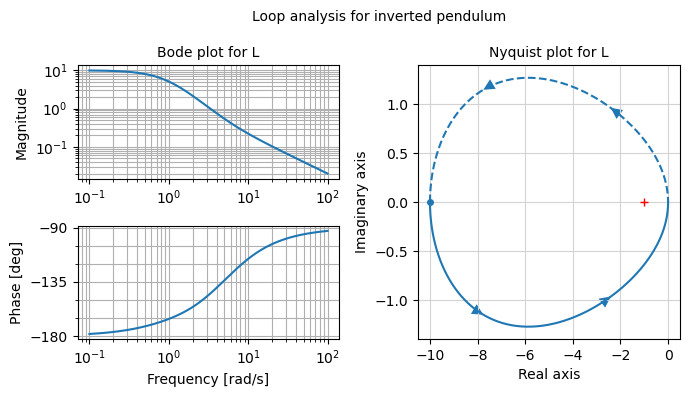

In [18]:
# Bode and Nyquist plots
plt.figure(figsize=[7, 4])
ax1 = plt.subplot(2, 2, 1)
plt.title("Bode plot for L", size='medium')
ax2 = plt.subplot(2, 2, 3)
ct.bode_plot(L, ax=[ax1, ax2])

ax3 = plt.subplot(1, 2, 2)
ct.nyquist_plot(L, ax=ax3)
plt.title("Nyquist plot for L", size='medium')

ct.suptitle("Loop analysis for inverted pendulum")
plt.tight_layout()

N = encirclements:  -1
P = RHP poles of L:  1
Z = N + P = RHP zeros of 1 + L: 0
Poles of L =  [-1.05124922+0.j  0.95124922+0.j]
Zeros of 1 + L =  [-1.05+2.8102491j -1.05-2.8102491j]



/Users/murray/Library/CloudStorage/Dropbox/macosx/src/python-control/murrayrm/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


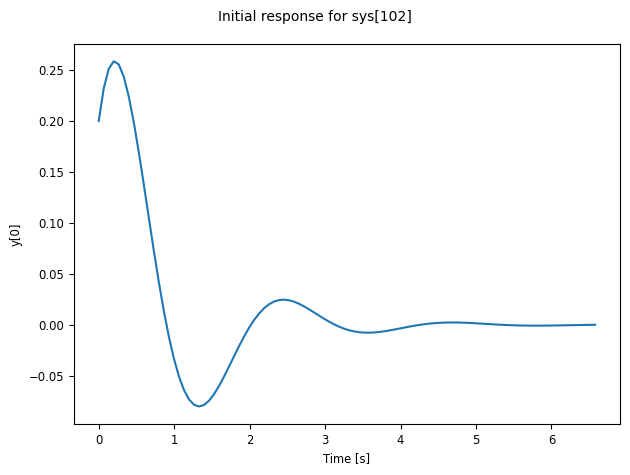

In [19]:
# Check the Nyquist criterion
nyqresp = ct.nyquist_response(L)
print("N = encirclements: ", nyqresp.count)
print("P = RHP poles of L: ", np.sum(np.real(L.poles()) > 0))
print("Z = N + P = RHP zeros of 1 + L:", np.sum(np.real((1 + L).zeros()) >= 0))
print("Poles of L = ", L.poles())
print("Zeros of 1 + L = ", (1 + L).zeros())
print("")

T = ct.feedback(L)
ct.initial_response(T, X0=[0.1, 0]).plot();

### Gang of 4

Another useful thing to look at is the transfer functions from noise and disturbances to the system outputs and inputs:

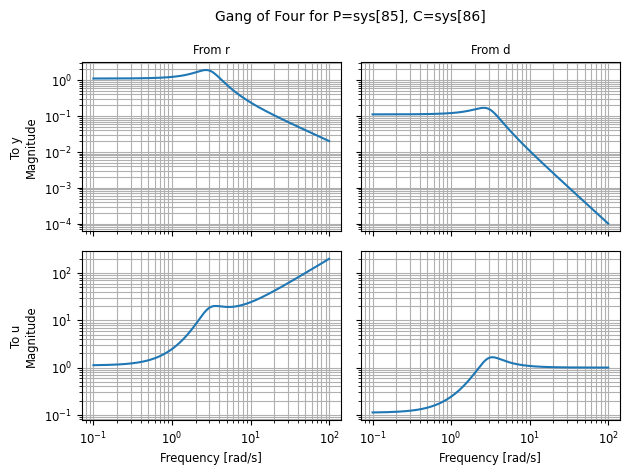

In [20]:
ct.gangof4(P, C);

We see that the response from the input $r$ (or equivalently noise $n$) to the process input is very large for large frequencies.  This means that we are amplifying high frequency noise (and comes from the fact that we used derivative feedback).

### High frequency rolloff

We can attempt to resolve this by "rolling off" the derivative action at high frequencies:

<TransferFunction>: Cnew
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  800 s + 4000
----------------
s^2 + 40 s + 400



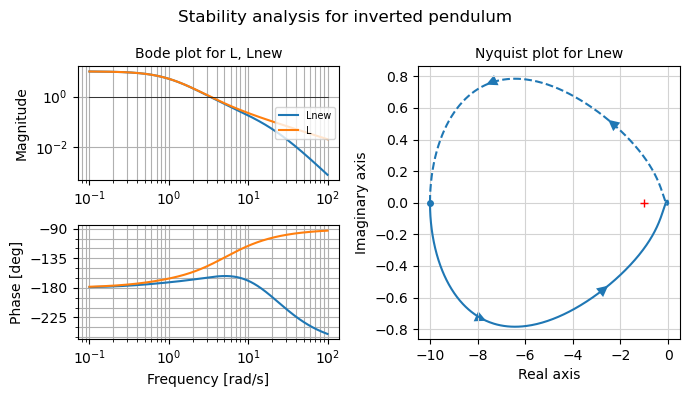

In [21]:
Cnew = (kp + kd * s) / (s/20 + 1)**2
Cnew.name = 'Cnew'
print(Cnew)

Lnew = P * Cnew
Lnew.name = 'Lnew'

plt.figure(figsize=[7, 4])
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3)
ct.bode_plot([Lnew, L], ax=[ax1, ax2])
ax1.loglog([1e-1, 1e2], [1, 1], 'k', linewidth=0.5)
ax1.set_title("Bode plot for L, Lnew", size='medium')

ax3 = plt.subplot(1, 2, 2)
ct.nyquist_plot(Lnew, ax=ax3)
ax3.set_title("Nyquist plot for Lnew", size='medium')

plt.suptitle("Stability analysis for inverted pendulum")
plt.tight_layout()

While not (yet) a very high performing controller, this change does get rid of the issues with the high frequency noise:

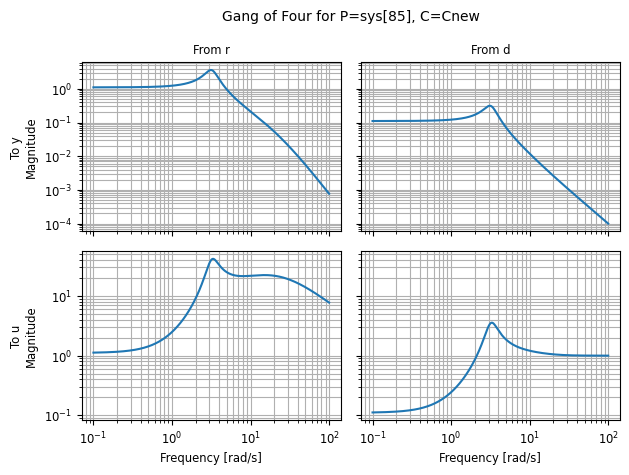

In [22]:
# Check the gang of 4
ct.gangof4(P, Cnew);

array([[list([<matplotlib.lines.Line2D object at 0x1454d2ea0>])]],
      dtype=object)

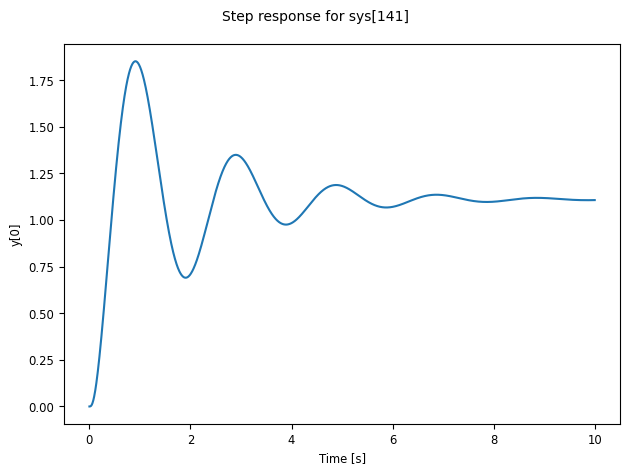

In [23]:
# See what the step response looks like
Tnew = ct.feedback(Lnew)
ct.step_response(Tnew, 10).plot()